In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing all required libraries
import pickle
#import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn import ensemble
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBClassifier
#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.feature_selection import mutual_info_classif,SelectPercentile
import warnings
warnings.filterwarnings('ignore')

In [ ]:
 import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [ ]:
#loading dataset into pandas dataframe
dataframe = pd.read_csv('/content/drive/MyDrive/mohan_ml_cold_start/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt')
dataframe.head(10)

,app,func,end_timestamp,duration
0,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,e3cdb48830f66eb8689cc0223514569a69812b77e6611e...,0.079491,0.078
1,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b7...,57.157860,57.154
2,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037...,59.130478,59.125
3,f274d71de386ccc77e4ca74766dbc485461c3053059d47...,3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef...,6.252541,6.236
4,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,68bbfd828223a505d7917339f4656c5f33ff93225cdb9d...,0.066824,0.050
5,f7bfe5bc8d2a37a5c15986fbfc2c477a746e866adcb966...,34f4775366e51728635af48df1a96d332cf1565eee069a...,0.099991,0.078
6,85479ef37b5dc75dd5aeca3bab499129b97a134dac5d74...,49535532e285d1ef68b0a7b8c3bc3973b36ec38a4c594e...,2.251979,2.229
7,85479ef37b5dc75dd5aeca3bab499129b97a134dac5d74...,e6df36937abcf1f6d0be4f2e3ffd12d98717dd6f29a9cd...,1.298016,1.275
8,85479ef37b5dc75dd5aeca3bab499129b97a134dac5d74...,cd9f7f333d59aede8088772edac3bff78c45e2dad8eb49...,62.329188,62.306
9,85479ef37b5dc75dd5aeca3bab499129b97a134dac5d74...,e02465de583b6ceffa5b78cce5f10eb27e714a8a6b3aed...,2.218287,2.195


In [ ]:
#shape of dataset
dataframe.shape

(1980951, 4)

In [ ]:
# dataframe=dataframe.head(300000)

In [ ]:
dataframe.shape

(1980951, 4)

In [ ]:
#datatypes of dataset
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980951 entries, 0 to 1980950
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   app            object 
 1   func           object 
 2   end_timestamp  float64
 3   duration       float64
dtypes: float64(2), object(2)
memory usage: 60.5+ MB


In [ ]:
#stats of dataset
dataframe.describe()

,end_timestamp,duration
count,1.980951e+06,1.980951e+06
mean,5.663581e+05,3.347944e+00
std,3.518276e+05,1.850717e+01
min,6.682396e-02,0.000000e+00
25%,2.497272e+05,1.000000e-03
50%,5.040002e+05,3.100000e-02
75%,8.701523e+05,3.720000e-01
max,1.209600e+06,5.786200e+02


In [ ]:
dataframe.dropna(inplace=True)

In [ ]:
#checking for null values
dataframe.isna().sum()

,0
app,0
func,0
end_timestamp,0
duration,0


In [ ]:
dataframe.columns

Index(['app', 'func', 'end_timestamp', 'duration'], dtype='object')

# **Data Preprocessing**

In [ ]:
dataframe['counter'] = range(1,len(dataframe)+1)
dataframe['start_timestamp'] = (dataframe['end_timestamp']-dataframe['duration'])
date = '2025-05-31'
time = '00:00:00.0'
start_date = datetime.strptime(date + ' ' + time, "%Y-%m-%d %H:%M:%S.%f")
dataframe['datetime'] = start_date + pd.TimedeltaIndex(dataframe['start_timestamp'], unit='s')
dataframe['date'] = dataframe['datetime']
dataframe = dataframe.set_index('datetime')
dataframe['DatetimeNumeric'] = pd.to_datetime(dataframe['date'])
dataframe['DatetimeNumeric'] = dataframe['DatetimeNumeric'].map(datetime.timestamp)
dataframe['wait'] = round(dataframe['start_timestamp'].diff()*1000,0)
dataframe.wait = dataframe.wait.fillna(0).astype(int)

In [ ]:
def interQuartile(df_):
  for x in ['wait']:
      q75,q25 = np.percentile(df_.loc[:,x],[75,25])
      intr_qr = q75-q25

      max = q75+(1.5*intr_qr)
      min = q25-(1.5*intr_qr)

      df_.loc[df_[x] < min,x] = np.nan
      df_.loc[df_[x] > max,x] = np.nan

  df_ = df_.dropna(axis = 0)
  df_.isnull().sum()
  return df_

In [ ]:
# 12/02/2021 12:00 - 18:00
dataframe1 = dataframe.copy()
start_date_obj = datetime.strptime('2025-06-12 12', "%Y-%m-%d %H")
end_date_obj = datetime.strptime('2025-06-12 18', "%Y-%m-%d %H")
mask = (dataframe1['date'] > start_date_obj) & (dataframe1['date'] <= end_date_obj)
dataframe1 = dataframe1.loc[mask]

In [ ]:
# 31/01/2021 00:00 - 12/02/2021 18:00
dataframe2 = dataframe.copy()
start_date_obj = datetime.strptime('2025-05-31', "%Y-%m-%d")
end_date_obj = datetime.strptime('2025-06-12 18', "%Y-%m-%d %H")
mask = (dataframe2['date'] > start_date_obj) & (dataframe2['date'] <= end_date_obj)
dataframe2 = dataframe2.loc[mask]

<Axes: >

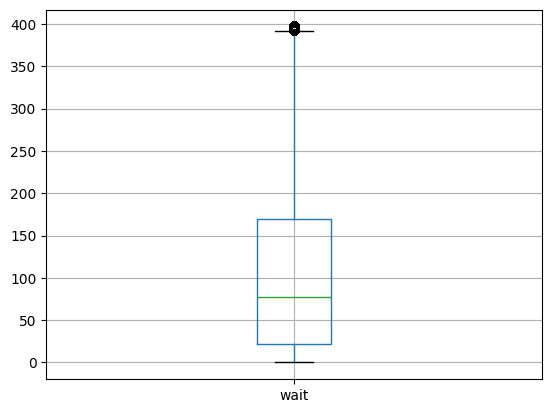

In [ ]:

dataframe2 = interQuartile(dataframe2)
dataframe2 = interQuartile(dataframe2)
dataframe2 = interQuartile(dataframe2)
dataframe2 = interQuartile(dataframe2)
dataframe2 = interQuartile(dataframe2)
dataframe2 = interQuartile(dataframe2)
dataframe2 = interQuartile(dataframe2)
dataframe2 = interQuartile(dataframe2)
dataframe2 = interQuartile(dataframe2)
dataframe2 = interQuartile(dataframe2)

wait_col = ['wait']
dataframe2.boxplot(wait_col)

# **Azure Dataset for JMeter**

In [ ]:
dataframetemp = dataframe.copy()
dataframetemp = dataframetemp.drop(['counter', 'DatetimeNumeric', 'wait'], axis=1)
dataframetemp = dataframetemp[::5]
dataframetemp = dataframetemp[::2]
dataframetemp['func'] = '155e47f8e7f751d0c845049456d01832013c61336a8cd85901330ac821a71534'
dataframetemp['counter'] = range(1,len(dataframetemp)+1)
dataframetemp['wait'] = round(dataframetemp['start_timestamp'].diff()*1000,0)
dataframetemp.wait = dataframetemp.wait.fillna(0).astype(int)
#df_2_copy.tail()
dataframetemp

,app,func,end_timestamp,duration,start_timestamp,date,counter,wait
datetime,,,,,,,,
2025-05-31 00:00:00.001490900,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,7.949090e-02,0.078,1.490900e-03,2025-05-31 00:00:00.001490900,1,0
2025-05-31 00:00:00.023377897,85479ef37b5dc75dd5aeca3bab499129b97a134dac5d74...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.421378e+00,1.398,2.337790e-02,2025-05-31 00:00:00.023377897,2,22
2025-05-31 00:00:00.190778889,734272c01926d19690e5ec308bab64ef97950b75b1c758...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.201779e+00,1.011,1.907789e-01,2025-05-31 00:00:00.190778889,3,167
2025-05-31 00:00:15.345119907,734272c01926d19690e5ec308bab64ef97950b75b1c758...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,3.656681e+02,350.323,1.534512e+01,2025-05-31 00:00:15.345119907,4,15154
2025-05-31 00:00:33.804311077,7fa05b607ae861b85ec53cea12d3efaed8be0f9a92f5d6...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,7.278731e+01,38.983,3.380431e+01,2025-05-31 00:00:33.804311077,5,18459
...,...,...,...,...,...,...,...,...
2025-06-13 23:59:38.958736965,5fb02cfeb979fec16df02d1ece227157238477b19fc6e3...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.209579e+06,0.078,1.209579e+06,2025-06-13 23:59:38.958736965,198092,3912
2025-06-13 23:59:43.074665951,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.209583e+06,0.001,1.209583e+06,2025-06-13 23:59:43.074665951,198093,4116
2025-06-13 23:59:46.210042881,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.209586e+06,0.001,1.209586e+06,2025-06-13 23:59:46.210042881,198094,3135


In [ ]:
dataframetemp.tail()

,app,func,end_timestamp,duration,start_timestamp,date,counter,wait
datetime,,,,,,,,
2025-06-13 23:59:38.958736965,5fb02cfeb979fec16df02d1ece227157238477b19fc6e3...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.209579e+06,0.078,1.209579e+06,2025-06-13 23:59:38.958736965,198092,3912
2025-06-13 23:59:43.074665951,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.209583e+06,0.001,1.209583e+06,2025-06-13 23:59:43.074665951,198093,4116
2025-06-13 23:59:46.210042881,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.209586e+06,0.001,1.209586e+06,2025-06-13 23:59:46.210042881,198094,3135
2025-06-13 23:59:53.999648975,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.209594e+06,0.001,1.209594e+06,2025-06-13 23:59:53.999648975,198095,7790
2025-06-13 23:59:59.693463969,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.209600e+06,0.001,1.209600e+06,2025-06-13 23:59:59.693463969,198096,5694


In [ ]:
dataframetemp.to_csv('/content/drive/MyDrive/mohan_ml_cold_start/Experiment_AzureDataset.csv', sep=',', encoding='utf-8')

In [ ]:
dataframetemp['Hour'] = dataframetemp.index.hour
dataframetemp['Minute'] = dataframetemp.index.minute
dataframetemp['Year'] = dataframetemp.index.year
dataframetemp['Month'] = dataframetemp.index.month
dataframetemp['Day'] = dataframetemp.index.day
dataframetemp.head()

,app,func,end_timestamp,duration,start_timestamp,date,counter,wait,Hour,Minute,Year,Month,Day
datetime,,,,,,,,,,,,,
2025-05-31 00:00:00.001490900,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,0.079491,0.078,0.001491,2025-05-31 00:00:00.001490900,1,0,0,0,2025,5,31
2025-05-31 00:00:00.023377897,85479ef37b5dc75dd5aeca3bab499129b97a134dac5d74...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.421378,1.398,0.023378,2025-05-31 00:00:00.023377897,2,22,0,0,2025,5,31
2025-05-31 00:00:00.190778889,734272c01926d19690e5ec308bab64ef97950b75b1c758...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.201779,1.011,0.190779,2025-05-31 00:00:00.190778889,3,167,0,0,2025,5,31
2025-05-31 00:00:15.345119907,734272c01926d19690e5ec308bab64ef97950b75b1c758...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,365.668120,350.323,15.345120,2025-05-31 00:00:15.345119907,4,15154,0,0,2025,5,31
2025-05-31 00:00:33.804311077,7fa05b607ae861b85ec53cea12d3efaed8be0f9a92f5d6...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,72.787311,38.983,33.804311,2025-05-31 00:00:33.804311077,5,18459,0,0,2025,5,31


In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
# from io import BytesIO

# edadf = dataframetemp[['Month', 'wait']].groupby(['Month']).mean()
# edadf = edadf.reset_index()
# fig = px.bar(edadf, x='Month', y='wait', color="Month", title="Avg wait by Month")
# fig.show()
# file_name="monthly_graph.png"
#fig.write_image(file_name)
#upload_file_to_s3(file_name, bucket_name)

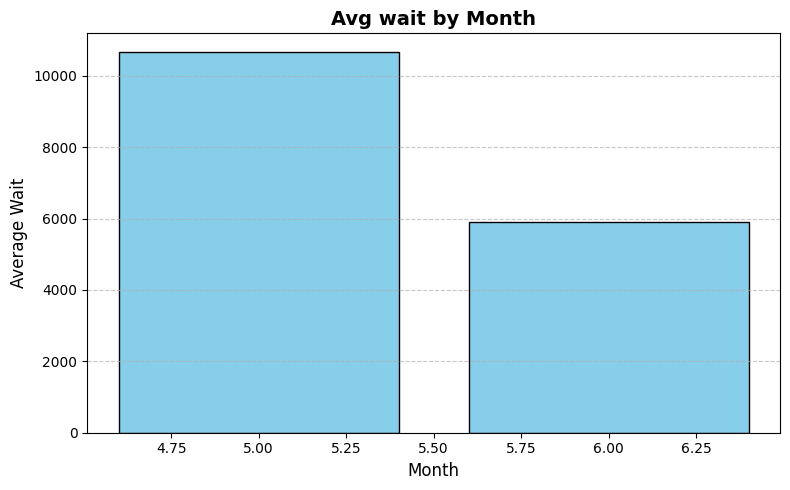

In [ ]:
# Group by month and compute mean
edadf = dataframetemp[['Month', 'wait']].groupby(['Month']).mean().reset_index()

# Create bar plot using Matplotlib
plt.figure(figsize=(8, 5))
plt.bar(edadf['Month'], edadf['wait'], color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Avg wait by Month', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Wait', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
file_name = "monthly_graph.png"
plt.tight_layout()
plt.savefig(file_name, dpi=300)
plt.show()

In [ ]:
# edadf = dataframetemp[['Day', 'wait']].groupby(['Day']).mean()
# edadf = edadf.reset_index()
# edadf.head()
# fig = px.line(edadf, x='Day', y='wait', title="Avg wait by Day", color_discrete_sequence=['indianred'])
# fig.show()
# file_name="day_graph.png"
#fig.write_image(file_name)
#upload_file_to_s3(file_name, bucket_name)

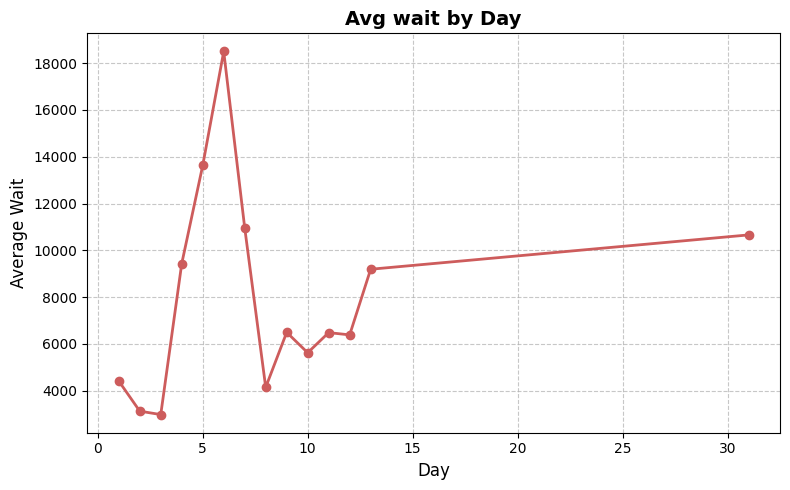

In [ ]:
# Group by Day and compute mean
edadf = dataframetemp[['Day', 'wait']].groupby(['Day']).mean().reset_index()

# Create line plot using Matplotlib
plt.figure(figsize=(8, 5))
plt.plot(edadf['Day'], edadf['wait'], color='indianred', marker='o', linewidth=2)

# Add titles and labels
plt.title('Avg wait by Day', fontsize=14, fontweight='bold')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Average Wait', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Save the figure
file_name = "day_graph.png"
plt.tight_layout()
plt.savefig(file_name, dpi=300)
plt.show()

In [ ]:
# edadf = dataframetemp[['Hour', 'wait']].groupby(['Hour']).mean()
# edadf = edadf.reset_index()
# edadf.head()
# fig = px.pie(edadf, names='Hour', values='wait', title="Avg wait by Hour")
# fig.show()
# file_name="hour_graph.png"
#fig.write_image(file_name)
#upload_file_to_s3(file_name, bucket_name)

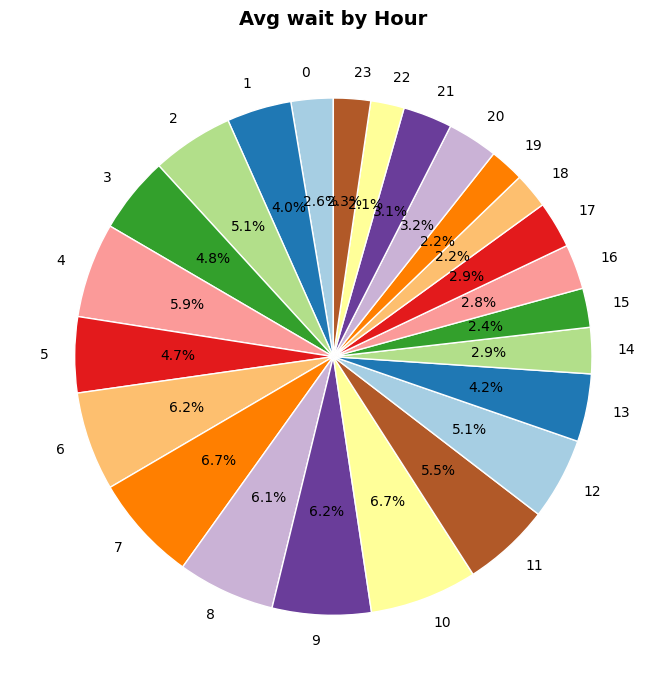

In [ ]:
edadf = dataframetemp[['Hour', 'wait']].groupby(['Hour']).mean().reset_index()

# Create pie chart using Matplotlib
plt.figure(figsize=(7, 7))
plt.pie(
    edadf['wait'],
    labels=edadf['Hour'],
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors,  # you can change colormap if you want
    wedgeprops={'edgecolor': 'white'}
)

# Add title
plt.title('Avg wait by Hour', fontsize=14, fontweight='bold')

# Save the figure
file_name = "hour_graph.png"
plt.tight_layout()
plt.savefig(file_name, dpi=300)
plt.show()

In [ ]:
edadf = dataframetemp[['Minute', 'wait']].groupby(['Minute']).mean().sort_values('wait', ascending=False)
edadf = edadf.reset_index()
edadf.head()
fig = px.area(edadf, x='Minute', y='wait', title="Avg wait by Minute", color_discrete_sequence=['green'])
fig.show()
file_name="minute_graph.png"
#fig.write_image(file_name)
#upload_file_to_s3(file_name, bucket_name)

In [ ]:
# # Group by Minute, compute mean, and sort descending by 'wait'
# edadf = dataframetemp[['Minute', 'wait']].groupby(['Minute']).mean().sort_values('wait', ascending=False).reset_index()

# # Create area chart using Matplotlib
# plt.figure(figsize=(8, 5))
# plt.fill_between(edadf['Minute'], edadf['wait'], color='green', alpha=0.4)
# plt.plot(edadf['Minute'], edadf['wait'], color='green', linewidth=2)

# # Add titles and labels
# plt.title('Avg wait by Minute', fontsize=14, fontweight='bold')
# plt.xlabel('Minute', fontsize=12)
# plt.ylabel('Average Wait', fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.7)

# # Save the figure
# file_name = "minute_graph.png"
# plt.tight_layout()
# plt.savefig(file_name, dpi=300)
# plt.show()

In [ ]:
# edadf = dataframetemp[['Hour', 'Minute', 'wait']].groupby(['Hour', 'Minute']).mean()
# edadf = edadf.reset_index()
# edadf.head()
# fig = px.line(edadf, x='Minute', y='wait', color='Hour', title='Avg wait by Hour & Minute', markers=True)
# fig.show()
# file_name="hour_minute_graph.png"
#fig.write_image(file_name)
#upload_file_to_s3(file_name, bucket_name)

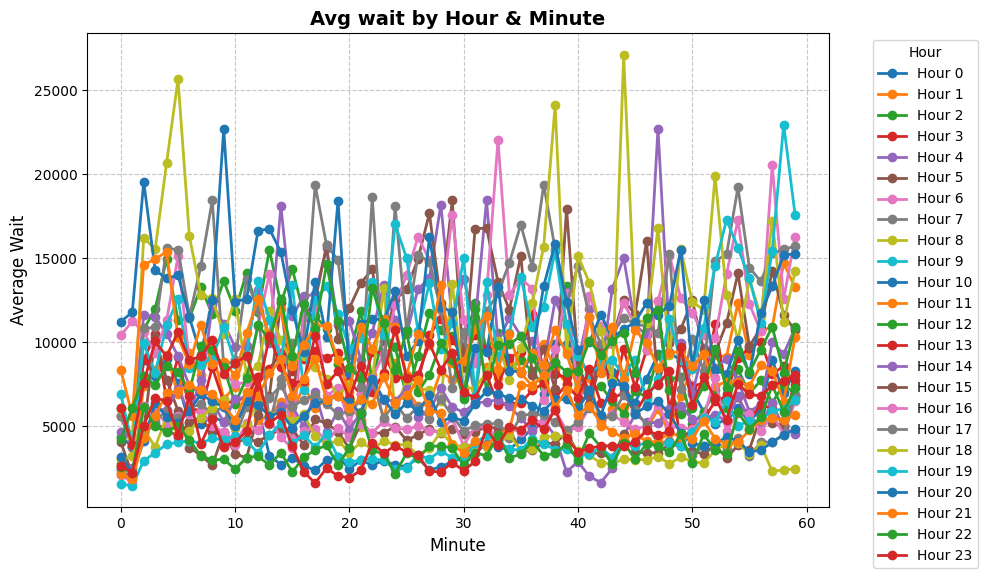

In [ ]:
# Group by Hour and Minute, compute mean
edadf = dataframetemp[['Hour', 'Minute', 'wait']].groupby(['Hour', 'Minute']).mean().reset_index()

# Create a line plot for each Hour
plt.figure(figsize=(10, 6))
for hour in sorted(edadf['Hour'].unique()):
    subset = edadf[edadf['Hour'] == hour]
    plt.plot(subset['Minute'], subset['wait'], marker='o', linewidth=2, label=f'Hour {hour}')

# Add titles, labels, and legend
plt.title('Avg wait by Hour & Minute', fontsize=14, fontweight='bold')
plt.xlabel('Minute', fontsize=12)
plt.ylabel('Average Wait', fontsize=12)
plt.legend(title='Hour', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

# Save the figure
file_name = "hour_minute_graph.png"
plt.tight_layout()
plt.savefig(file_name, dpi=300)
plt.show()

In [ ]:
# edadf = dataframetemp[['Hour', 'Day', 'wait']].groupby(['Hour', 'Day']).mean()
# edadf = edadf.reset_index()
# edadf['Day'] = edadf['Day'].astype(str)
# edadf.head()
# fig = px.bar(edadf, x='Day', y='wait', color='Hour', title='Avg wait by Hour & Day')
# fig.show()
# file_name="hour_day_graph.png"
# fig.write_image(file_name)
# upload_file_to_s3(file_name, bucket_name)

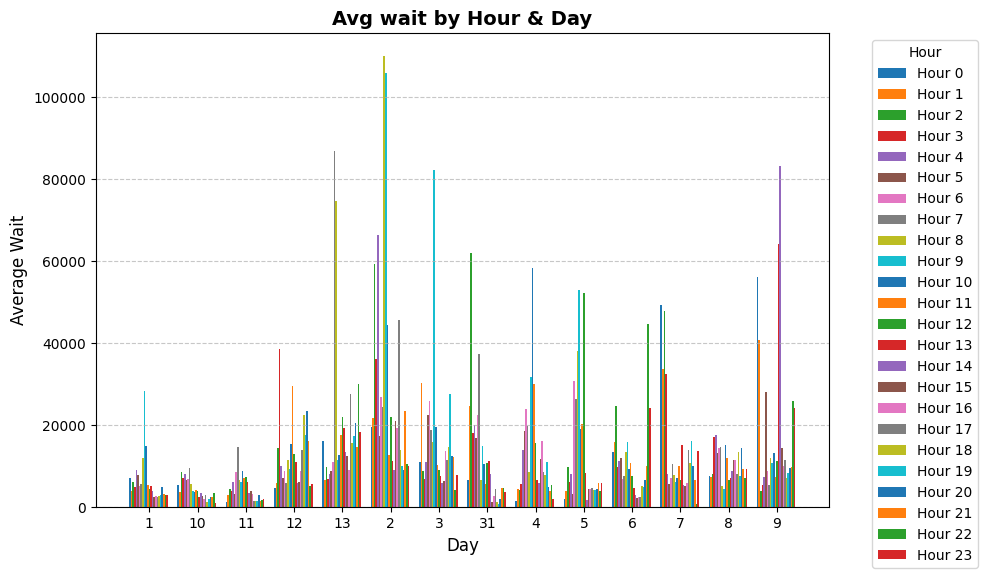

In [ ]:
# Group by Hour and Day, compute mean
edadf = dataframetemp[['Hour', 'Day', 'wait']].groupby(['Hour', 'Day']).mean().reset_index()
edadf['Day'] = edadf['Day'].astype(str)

# Prepare data for grouped bars
days = sorted(edadf['Day'].unique())
hours = sorted(edadf['Hour'].unique())
bar_width = 0.8 / len(hours)
x = np.arange(len(days))

plt.figure(figsize=(10, 6))

# Plot one bar group per hour
for i, hour in enumerate(hours):
    subset = edadf[edadf['Hour'] == hour]
    plt.bar(x + i * bar_width, subset['wait'], width=bar_width, label=f'Hour {hour}')

# Format axes and labels
plt.xticks(x + bar_width * (len(hours) / 2), days)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Average Wait', fontsize=12)
plt.title('Avg wait by Hour & Day', fontsize=14, fontweight='bold')
plt.legend(title='Hour', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
file_name = "hour_day_graph.png"
plt.tight_layout()
plt.savefig(file_name, dpi=300)
plt.show()

In [ ]:
# edadf = dataframetemp[['Minute', 'Day', 'wait']].groupby(['Minute', 'Day']).mean()
# edadf = edadf.reset_index()
# edadf['Day'] = edadf['Day'].astype(str)
# edadf.head()
# fig = px.scatter(edadf, x='Day', y='wait', color='Minute', title='Avg wait by Minute & Day', )
# fig.show()
# file_name="minute_day_graph.png"
# fig.write_image(file_name)
# upload_file_to_s3(file_name, bucket_name)

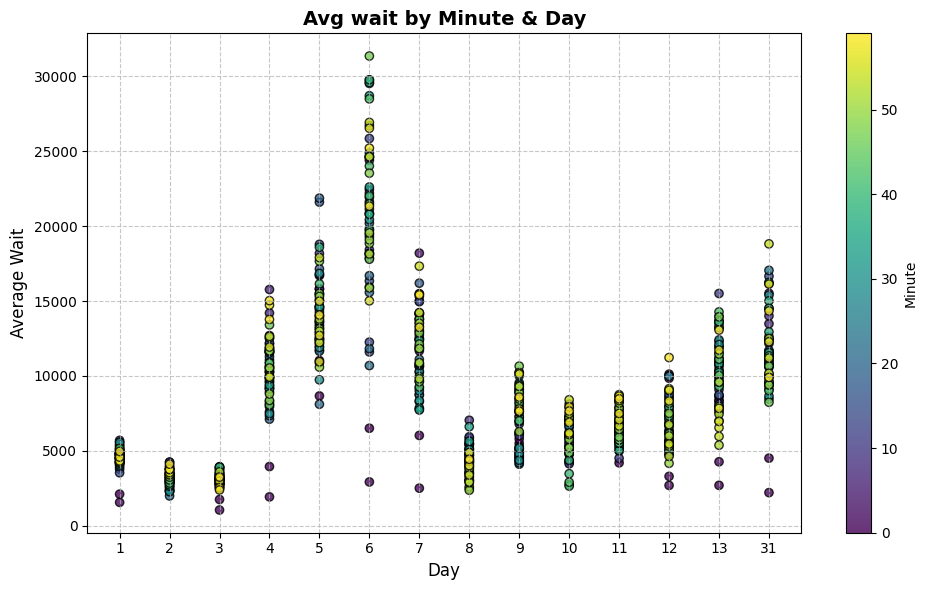

In [ ]:
# Group by Minute and Day, compute mean
edadf = dataframetemp[['Minute', 'Day', 'wait']].groupby(['Minute', 'Day']).mean().reset_index()
edadf['Day'] = edadf['Day'].astype(str)

# Create scatter plot using Matplotlib
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    edadf['Day'], edadf['wait'],
    c=edadf['Minute'],                # color by Minute
    cmap='viridis',                   # color map for gradient effect
    alpha=0.8,
    edgecolor='k'
)

# Add colorbar, titles, and labels
plt.colorbar(scatter, label='Minute')
plt.title('Avg wait by Minute & Day', fontsize=14, fontweight='bold')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Average Wait', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Save the figure
file_name = "minute_day_graph.png"
plt.tight_layout()
plt.savefig(file_name, dpi=300)
plt.show()

# **Data Preprocessing for ML**

In [ ]:
finaldata = dataframe2[['wait','DatetimeNumeric']]
finaldata['hour'] = finaldata.index.hour
finaldata['day'] = finaldata.index.day

# Day
finaldata['day_sin'] = np.sin(finaldata.day*(2.*np.pi/30))
finaldata['day_cos'] = np.cos(finaldata.day*(2.*np.pi/30))
# Hour
finaldata['hour_sin'] = np.sin(finaldata.day*(2.*np.pi/24))
finaldata['hour_cos'] = np.cos(finaldata.day*(2.*np.pi/24))
# Minute
finaldata['minute_sin'] = np.sin(finaldata.day*(2.*np.pi/60))
finaldata['minute_cos'] = np.cos(finaldata.day*(2.*np.pi/60))
finaldata = finaldata.drop(['hour','day','DatetimeNumeric'], axis=1)
finaldata.tail()

,wait,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos
datetime,,,,,,,
2025-06-12 17:58:04.719836886,118.0,0.587785,-0.809017,1.224647e-16,-1.0,0.951057,0.309017
2025-06-12 17:58:04.797518908,78.0,0.587785,-0.809017,1.224647e-16,-1.0,0.951057,0.309017
2025-06-12 17:58:05.002832901,205.0,0.587785,-0.809017,1.224647e-16,-1.0,0.951057,0.309017
2025-06-12 17:58:05.206281984,203.0,0.587785,-0.809017,1.224647e-16,-1.0,0.951057,0.309017
2025-06-12 17:58:05.408119047,202.0,0.587785,-0.809017,1.224647e-16,-1.0,0.951057,0.309017


In [ ]:
finaldataml = finaldata

In [ ]:
finaldataml = finaldataml.reset_index()
finaldataml = finaldataml[['wait']]

In [ ]:
finaldataml = np.array(finaldataml).reshape(-1,1)

In [ ]:
training_size=int(len(finaldataml)*0.90)
test_size=len(finaldataml)-training_size
train_data,test_data=finaldataml[0:training_size,:],finaldataml[training_size:len(finaldataml),:1]

In [ ]:
# apply window rolling timestep
def windowrollingdata(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 5
x_train, y_train = windowrollingdata(train_data, time_step)
x_test, y_test = windowrollingdata(test_data, time_step)

In [ ]:
x_train.shape

(1171166, 5)

In [ ]:
x_train

array([[  0.,   2.,   2.,  11.,   0.],
       [  2.,   2.,  11.,   0.,   5.],
       [  2.,  11.,   0.,   5.,   1.],
       ...,
       [  1.,   1., 119.,  71.,  92.],
       [  1., 119.,  71.,  92.,  82.],
       [119.,  71.,  92.,  82., 274.]])

In [ ]:
y_train

array([  5.,   1.,   0., ...,  82., 274.,  99.])

# **Deep Learning Models**

#Data Preparation

In [ ]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

In [ ]:
finaldata = finaldata.reset_index()
finaldata = finaldata[['wait']]

In [ ]:
def windowrolling(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 5
X, y = windowrolling(finaldata, WINDOW_SIZE)
X.shape, y.shape

((1301298, 5, 1), (1301298,))

In [ ]:
finaldata = finaldata.reset_index()
finaldata = finaldata[['wait']]

#finaldata = np.array(finaldata).reshape(-1,1)

In [ ]:
#splitting data into train, val and test with ratio of 80:10:10
X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(X)*0.8)]
X_val, y_val = X[int(len(X)*0.8):int(len(X)*0.9)], y[int(len(X)*0.8):int(len(X)*0.9)]
X_test, y_test = X[int(len(X)*0.9):], y[int(len(X)*0.9):]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1041038, 5, 1),
 (1041038,),
 (130130, 5, 1),
 (130130,),
 (130130, 5, 1),
 (130130,))

In [ ]:
temp_training_mean = np.mean(X_train[:, :, 0])
temp_training_std = np.std(X_train[:, :, 0])

def preprocessing(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

#LSTM

In [ ]:
model = Sequential()
model.add(InputLayer((X_train.shape[1],X_train.shape[2])))
model.add(LSTM(units=64,  activation='relu', stateful=False))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
model.summary()

cp2 = ModelCheckpoint('/content/drive/MyDrive/mohan_ml_cold_start/lstm_model.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[RootMeanSquaredError()])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[cp2])

Epoch 1/5
32533/32533 ━━━━━━━━━━━━━━━━━━━━ 125s 4ms/step - loss: 9462.3340 - root_mean_squared_error: 97.2672 - val_loss: 8190.7666 - val_root_mean_squared_error: 90.5029
Epoch 2/5
32533/32533 ━━━━━━━━━━━━━━━━━━━━ 113s 3ms/step - loss: 9268.3838 - root_mean_squared_error: 96.2723 - val_loss: 8117.9653 - val_root_mean_squared_error: 90.0998
Epoch 3/5
32533/32533 ━━━━━━━━━━━━━━━━━━━━ 109s 3ms/step - loss: 9235.1143 - root_mean_squared_error: 96.0992 - val_loss: 8198.9229 - val_root_mean_squared_error: 90.5479
Epoch 4/5
32533/32533 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step - loss: 9257.8213 - root_mean_squared_error: 96.2171 - val_loss: 8111.8970 - val_root_mean_squared_error: 90.0661
Epoch 5/5
32533/32533 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step - loss: 9254.1475 - root_mean_squared_error: 96.1984 - val_loss: 8106.1108 - val_root_mean_squared_error: 90.0339


In [ ]:
model = load_model('/content/drive/MyDrive/mohan_ml_cold_start/lstm_model.keras')

32533/32533 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step


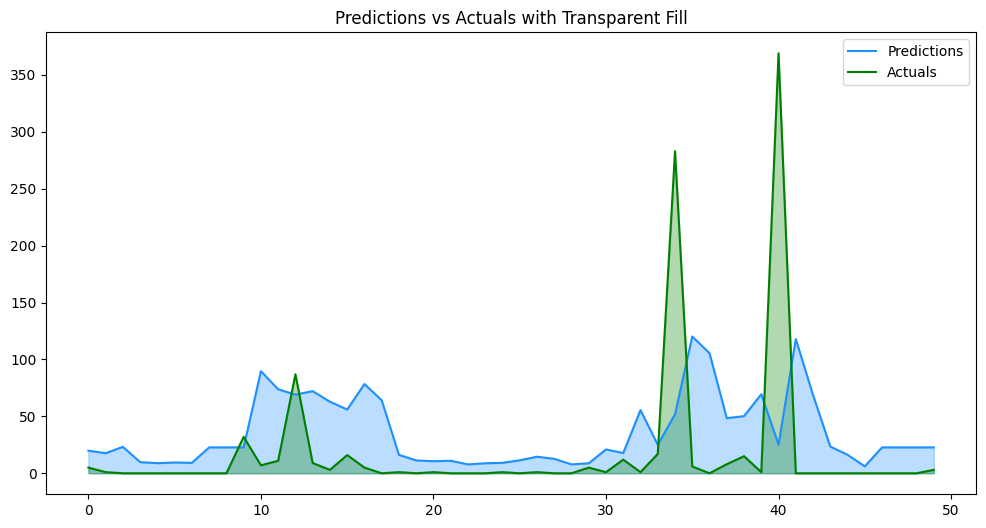

In [ ]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame({
    'Train Predictions': abs(train_predictions),
    'Actuals': y_train
})

plt.figure(figsize=(12,6))

# Plot lines
plt.plot(train_results['Train Predictions'][:50], color="dodgerblue", label="Predictions")
plt.plot(train_results['Actuals'][:50], color="green", label="Actuals")

# Fill areas with transparency
plt.fill_between(range(50),
                 train_results['Train Predictions'][:50],
                 alpha=0.3, color="dodgerblue")

plt.fill_between(range(50),
                 train_results['Actuals'][:50],
                 alpha=0.3, color="green")

plt.legend(loc="upper right")
plt.title("Predictions vs Actuals with Transparent Fill")
plt.show()


In [ ]:
test_predictions = model.predict(X_test).flatten()

4067/4067 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [ ]:
predicted = test_predictions
print('Mean Squared Error(MSE):', metrics.mean_squared_error(y_test, predicted))
print('Root Mean Squared Error(RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
predicted_value = predicted.reshape(-1, 1)
real_value = y_test.reshape(-1, 1)
testdataframe = pd.DataFrame({
  "Real": real_value.ravel(),
  "Predicted": predicted_value.ravel()
  })
testdataframe.head()

Mean Squared Error(MSE): 11079.326368588152
Root Mean Squared Error(RMSE): 105.2583790896865


,Real,Predicted
0,60.0,139.464188
1,236.0,142.482025
2,216.0,127.135933
3,317.0,143.279205
4,201.0,157.865845


4067/4067 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


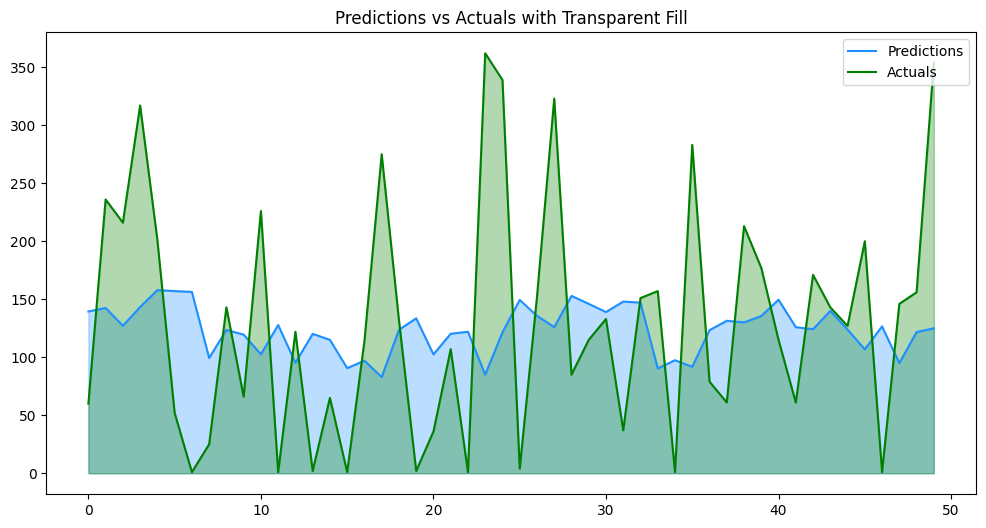

In [ ]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame({
    'Test Predictions': abs(test_predictions),
    'Actuals': y_test
})

plt.figure(figsize=(12,6))

# Plot lines
plt.plot(test_results['Test Predictions'][:50], color="dodgerblue", label="Predictions")
plt.plot(test_results['Actuals'][:50], color="green", label="Actuals")

# Fill areas with transparency
plt.fill_between(range(50),
                 test_results['Test Predictions'][:50],
                 alpha=0.3, color="dodgerblue")

plt.fill_between(range(50),
                 test_results['Actuals'][:50],
                 alpha=0.3, color="green")

plt.legend(loc="upper right")
plt.title("Predictions vs Actuals with Transparent Fill")
plt.show()


In [ ]:
test_results_copy = (testdataframe['Real']*60).astype(int)
test_results_copy = test_results_copy[::5]
test_results_copy = test_results_copy[::2]
test_results_copy = test_results_copy[:100]
test_results_copy.to_csv('/content/drive/MyDrive/mohan_ml_cold_start/experiment_lstm.csv', sep=',', encoding='utf-8')

#BiLSTM

In [ ]:
model = Sequential()
model.add(InputLayer((X_train.shape[1],X_train.shape[2])))
model.add(Bidirectional(LSTM(units=64,  activation='relu', stateful=False)))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
model.summary()

cp2 = ModelCheckpoint('/content/drive/MyDrive/mohan_ml_cold_start/bilstm_model.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[RootMeanSquaredError()])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,833 (136.07 KB)

 Trainable params: 34,833 (136.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64, callbacks=[cp2])

Epoch 1/5
16267/16267 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - loss: 9458.1016 - root_mean_squared_error: 97.2401 - val_loss: 8207.9219 - val_root_mean_squared_error: 90.5976
Epoch 2/5
16267/16267 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - loss: 9286.2461 - root_mean_squared_error: 96.3647 - val_loss: 8250.9014 - val_root_mean_squared_error: 90.8345
Epoch 3/5
16267/16267 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - loss: 9273.7051 - root_mean_squared_error: 96.2997 - val_loss: 8093.2891 - val_root_mean_squared_error: 89.9627
Epoch 4/5
16267/16267 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - loss: 9246.9727 - root_mean_squared_error: 96.1611 - val_loss: 8054.3125 - val_root_mean_squared_error: 89.7458
Epoch 5/5
16267/16267 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - loss: 9241.8271 - root_mean_squared_error: 96.1341 - val_loss: 8146.1948 - val_root_mean_squared_error: 90.2563


In [ ]:
model = load_model('/content/drive/MyDrive/mohan_ml_cold_start/bilstm_model.keras')

In [ ]:
# train_predictions = model.predict(X_train).flatten()
# train_results = pd.DataFrame(data={'Train Predictions':abs(train_predictions), 'Actuals':y_train})
# plt.plot(train_results['Train Predictions'][:200],label="Predictions")
# plt.plot(train_results['Actuals'][:200],label="Actuals")
# plt.legend(loc="upper right")

32533/32533 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step


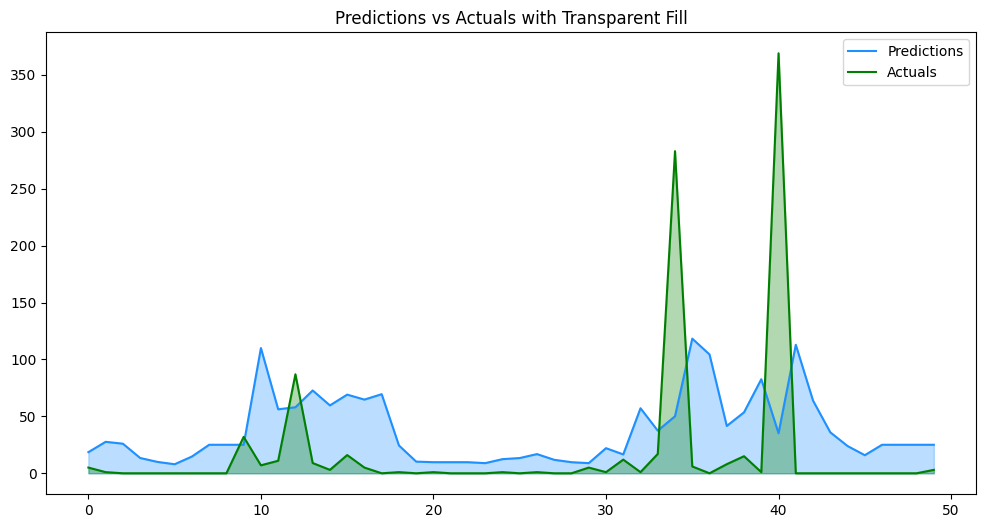

In [ ]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame({
    'Train Predictions': abs(train_predictions),
    'Actuals': y_train
})

plt.figure(figsize=(12,6))

# Plot lines
plt.plot(train_results['Train Predictions'][:50], color="dodgerblue", label="Predictions")
plt.plot(train_results['Actuals'][:50], color="green", label="Actuals")

# Fill areas with transparency
plt.fill_between(range(50),
                 train_results['Train Predictions'][:50],
                 alpha=0.3, color="dodgerblue")

plt.fill_between(range(50),
                 train_results['Actuals'][:50],
                 alpha=0.3, color="green")

plt.legend(loc="upper right")
plt.title("Predictions vs Actuals with Transparent Fill")
plt.show()




In [ ]:
test_predictions = model.predict(X_test).flatten()

4067/4067 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [ ]:
predicted = test_predictions
print('Mean Squared Error(MSE):', metrics.mean_squared_error(y_test, predicted))
print('Root Mean Squared Error(RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
predicted_value = predicted.reshape(-1, 1)
real_value = y_test.reshape(-1, 1)
testdataframe = pd.DataFrame({
  "Real": real_value.ravel(),
  "Predicted": predicted_value.ravel()
  })
testdataframe.head()

Mean Squared Error(MSE): 11033.345711989248
Root Mean Squared Error(RMSE): 105.03973396762412


,Real,Predicted
0,60.0,145.072083
1,236.0,136.384201
2,216.0,134.028336
3,317.0,141.004211
4,201.0,146.057526


In [ ]:
# test_predictions = model.predict(X_test).flatten()
# test_results = pd.DataFrame(data={'wait':abs(test_predictions), 'Actuals':y_test})
# plt.plot(test_results['Actuals'][:200],label="Actuals")
# plt.plot(test_results['wait'][:200],label="Predictions")
# plt.legend(loc="upper right")

4067/4067 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


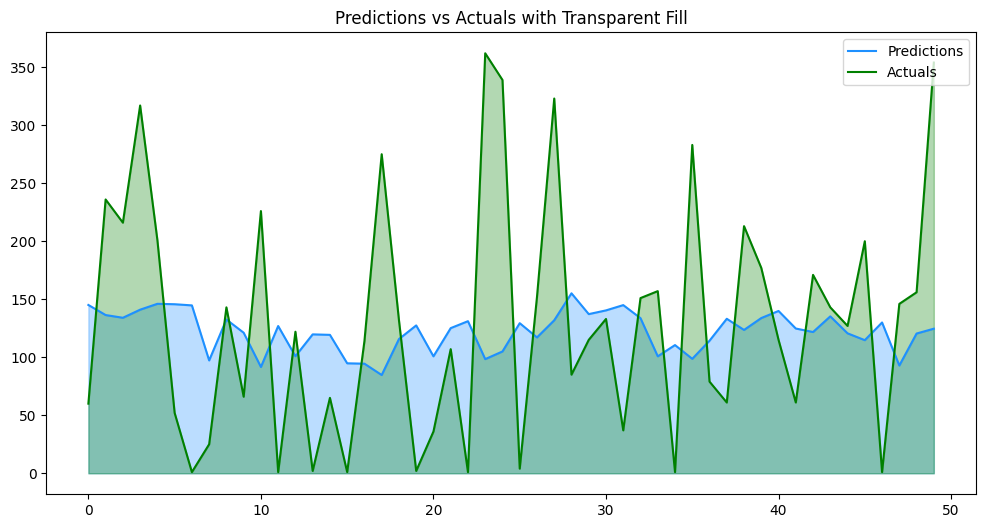

In [ ]:

test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame({
    'Test Predictions': abs(test_predictions),
    'Actuals': y_test
})

plt.figure(figsize=(12,6))

# Plot lines
plt.plot(test_results['Test Predictions'][:50], color="dodgerblue", label="Predictions")
plt.plot(test_results['Actuals'][:50], color="green", label="Actuals")

# Fill areas with transparency
plt.fill_between(range(50),
                 test_results['Test Predictions'][:50],
                 alpha=0.3, color="dodgerblue")

plt.fill_between(range(50),
                 test_results['Actuals'][:50],
                 alpha=0.3, color="green")

plt.legend(loc="upper right")
plt.title("Predictions vs Actuals with Transparent Fill")
plt.show()

In [ ]:
test_results_copy = (testdataframe['Real']*60).astype(int)
test_results_copy = test_results_copy[::5]
test_results_copy = test_results_copy[::2]
test_results_copy = test_results_copy[:100]
test_results_copy.to_csv('/content/drive/MyDrive/mohan_ml_cold_start/experiment_bilstm.csv', sep=',', encoding='utf-8')

Multiheaded BiLSTM

In [ ]:
from keras.models import Model
from keras.layers import Input, Bidirectional, LSTM, Dense, Concatenate
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError
from keras.callbacks import ModelCheckpoint

In [ ]:
# Input shape: (timesteps, features)
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Multi-headed BiLSTM (3 parallel branches for example)
head1 = Bidirectional(LSTM(64, activation='relu'))(input_layer)
head2 = Bidirectional(LSTM(64, activation='relu'))(input_layer)
head3 = Bidirectional(LSTM(64, activation='relu'))(input_layer)

# Concatenate the outputs
merged = Concatenate()([head1, head2, head3])

# Dense layers after merging
dense1 = Dense(64, activation='relu')(merged)
dense2 = Dense(8, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

# Build the model
model = Model(inputs=input_layer, outputs=output)

# Compile
model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(),
    metrics=[RootMeanSquaredError()]
)

# Checkpoint callback
cp2 = ModelCheckpoint('/content/drive/MyDrive/mohan_ml_cold_start/multiheaded_bilstm.keras', save_best_only=True)

# Summary
model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │     33,792 │ input_layer_4[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 128)       │     33,792 │ input_layer_4[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 128)       │     33,792 │ input_layer_4[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ bidirectional_3[… │
│ (Concatenate)       │                   │            │ bidirectional_4[… │
│                     │                   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │     24,640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 8)         │        520 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │          9 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 126,545 (494.32 KB)

 Trainable params: 126,545 (494.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[RootMeanSquaredError()])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64 ,callbacks=[cp2])

Epoch 1/5
16267/16267 ━━━━━━━━━━━━━━━━━━━━ 122s 7ms/step - loss: 9479.7520 - root_mean_squared_error: 97.3390 - val_loss: 8100.7734 - val_root_mean_squared_error: 90.0043
Epoch 2/5
16267/16267 ━━━━━━━━━━━━━━━━━━━━ 101s 6ms/step - loss: 9256.9082 - root_mean_squared_error: 96.2125 - val_loss: 8154.6812 - val_root_mean_squared_error: 90.3033
Epoch 3/5
16267/16267 ━━━━━━━━━━━━━━━━━━━━ 100s 6ms/step - loss: 9244.4600 - root_mean_squared_error: 96.1480 - val_loss: 8191.4712 - val_root_mean_squared_error: 90.5067
Epoch 4/5
16267/16267 ━━━━━━━━━━━━━━━━━━━━ 144s 6ms/step - loss: 9251.0938 - root_mean_squared_error: 96.1824 - val_loss: 8128.2480 - val_root_mean_squared_error: 90.1568
Epoch 5/5
16267/16267 ━━━━━━━━━━━━━━━━━━━━ 100s 6ms/step - loss: 9260.9854 - root_mean_squared_error: 96.2332 - val_loss: 8097.3145 - val_root_mean_squared_error: 89.9851


In [ ]:
multiheaded_bilstm = load_model('/content/drive/MyDrive/mohan_ml_cold_start/multiheaded_bilstm.keras')

In [ ]:
train_predictions = multiheaded_bilstm.predict(X_train).flatten()

32533/32533 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step


In [ ]:
# train_results = pd.DataFrame(data={'Train Predictions':abs(train_predictions), 'Actuals':y_train})
# plt.plot(train_results['Train Predictions'][:200],label="Predictions")
# plt.plot(train_results['Actuals'][:200],label="Actuals")
# plt.legend(loc="upper right")

32533/32533 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step


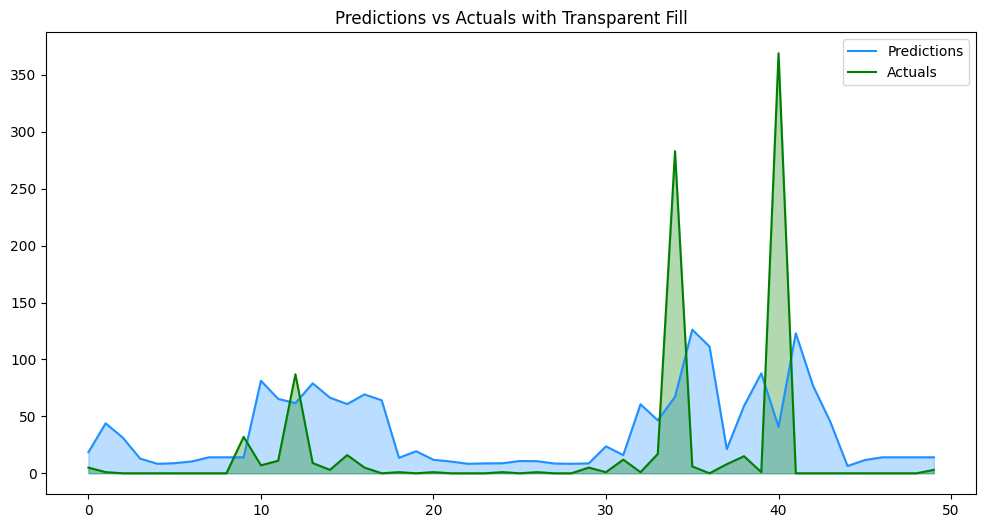

In [ ]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame({
    'Train Predictions': abs(train_predictions),
    'Actuals': y_train
})

plt.figure(figsize=(12,6))

# Plot lines
plt.plot(train_results['Train Predictions'][:50], color="dodgerblue", label="Predictions")
plt.plot(train_results['Actuals'][:50], color="green", label="Actuals")

# Fill areas with transparency
plt.fill_between(range(50),
                 train_results['Train Predictions'][:50],
                 alpha=0.3, color="dodgerblue")

plt.fill_between(range(50),
                 train_results['Actuals'][:50],
                 alpha=0.3, color="green")

plt.legend(loc="upper right")
plt.title("Predictions vs Actuals with Transparent Fill")
plt.show()


In [ ]:
test_predictions = bilstm_att_model.predict(X_test).flatten()

4067/4067 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


In [ ]:
predicted = test_predictions
print('Mean Squared Error(MSE):', metrics.mean_squared_error(y_test, predicted))
print('Root Mean Squared Error(RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
predicted_value = predicted.reshape(-1, 1)
real_value = y_test.reshape(-1, 1)
testdataframe = pd.DataFrame({
  "Real": real_value.ravel(),
  "Predicted": predicted_value.ravel()
  })
testdataframe.head()

Mean Squared Error(MSE): 10958.95832414579
Root Mean Squared Error(RMSE): 104.68504345963558


,Real,Predicted
0,60.0,148.182281
1,236.0,147.533463
2,216.0,146.228943
3,317.0,154.320908
4,201.0,162.425720


In [ ]:
test_results_copy = (testdataframe['Real']*60).astype(int)
test_results_copy = test_results_copy[::5]
test_results_copy = test_results_copy[::2]
test_results_copy = test_results_copy[:100]
test_results_copy.to_csv('/content/drive/MyDrive/mohan_ml_cold_start/experiment_multiheaded_bilstm.csv', sep=',', encoding='utf-8')

In [ ]:
# import os
# os.remove('/kaggle/working/experiment_multiheaded_bilstm.csv')
# os.remove('/kaggle/working/lstm_model.keras')
# os.remove('/kaggle/working/multiheaded_bilstm.keras')

